In [12]:
list_a = ['a', 'b', 'c']
list_b = [1, 2, 3]
for x,y in zip(list_a,list_b):
    print(x,y)


a 1
b 2
c 3


In [15]:
# 개와 고양이 binary classification 예제의 TFRecord 버전

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.notebook import tqdm
from PIL import Image
import io

############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)

# DataFrame을 하나 생성해요!
# DataFrame의 column은 2개를 사용해요. (경로포함한 filename, label)

src = '/content/drive/MyDrive/Machine Learning Colab/CAT_DOG/cat_dog_tfrecord/'

df = pd.DataFrame(os.listdir(src),
                  columns=['filename'])

df['label'] = ~df['filename'].str.contains('cat')

df = df.astype({'label' : 'int'})

df['filename'] = df['filename'].map(lambda x : src + x)

display(df)

### TFRecord 생성 함수 ###

# id_list : 이미지 파일명을 가지고 있는 list
# label_list : 이미지 파일의 label을 가지고 있는 list
# tfrecords_name : tfrecord 파일의 이름(train, validation용도로 파일을 따로 만들어야 하기 때문)

def to_tfrecords(id_list, label_list, tfrecords_name):
    print("converting 시작!!")

    options = tf.io.TFRecordOptions(compression_type='GZIP')

    with tf.io.TFRecordWriter(path=os.path.join(tfrecords_name + '.tfrecords'),
                              options=options) as writer:

        for id_, label_ in tqdm(zip(id_list,label_list),
                                total=len(id_list),
                                position=0,
                                leave=True):
            image_path = id_  # 이미지의 경로
            _binary_image = tf.io.read_file(image_path)  # 이미지 파일로부터 binary 데이터를 추출

            my_features = tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'label': _int64_feature(label_),
                'id': _bytes_feature(id_.encode())
            })

            string_set = tf.train.Example(features=my_features)

            writer.write(string_set.SerializeToString())

train_ids, val_ids, train_label, val_label = \
train_test_split(df['filename'],
                 df['label'],
                 test_size=0.2,
                 random_state=0)

# to_tfrecords(train_ids,train_label,'cat_dog_train')
to_tfrecords(val_ids,val_label,'cat_dog_valid')

,filename,label
0,/content/drive/MyDrive/Machine Learning Colab/...,0
1,/content/drive/MyDrive/Machine Learning Colab/...,0
2,/content/drive/MyDrive/Machine Learning Colab/...,0
3,/content/drive/MyDrive/Machine Learning Colab/...,0
4,/content/drive/MyDrive/Machine Learning Colab/...,0
...,...,...
3995,/content/drive/MyDrive/Machine Learning Colab/...,1
3996,/content/drive/MyDrive/Machine Learning Colab/...,1
3997,/content/drive/MyDrive/Machine Learning Colab/...,1
3998,/content/drive/MyDrive/Machine Learning Colab/...,1


converting 시작!!


KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 150, 150, 3) (64,)


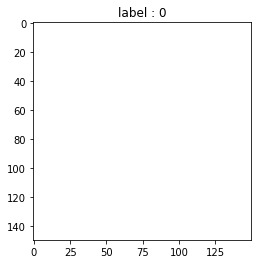

In [23]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# train, validation TFRecord 파일 경로
train_tfrecord_path = './cat_dog_train.tfrecords'


# TFRecord 파일을 불러와서 모델 학습 및 추론에 사용하기 위해서는 
# tf.data.Dataset 모듈과 유사한 기능을 가지는 tf.data.TFRecordDataset 모듈을 이용
# tf.data.Dataset 모듈은 여러 방식으로 데이터를 불러올 수 있는데 기본적으로는 
# generator로 부터 데이터를 불러온다. TFRecordDataset도 마찬가지임.
# 아래의 parameter는 TFRecordDataset를 사용할 때의 parameter

BUFFER_SIZE = 256     # 데이터 shuffle을 위한 buffer size
BATCH_SIZE = 64       # 배치 사이즈. 한번에 가져오는 이미지 데이터 개수 
NUM_CLASS = 2         # class의 개수. binary인 경우는 필요없으며 categorical인 경우 설정
IMAGE_SIZE = 150       


# TFRecord를 읽어서 데이터를 복원하기 위한 자료구조.
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
}

# 읽어들인 TFRecord를 다음의 형태(dict)로 변환하는 함수
# <ParallelMapDataset shapes: {id: (), image_raw: (), label: ()}, 
#                     types: {id: tf.string, image_raw: tf.string, label: tf.int64}>
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, 
                                      image_feature_description)

# 위에서 얻은 ParallelMapDataset를 다음의 형태(shape)로 변환하는 함수
# <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['label']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label


# 전처리(resize & augmentation) 함수
# 이미지 데이터 normalization
# 이 처리를 하는 대신 tf.keras.applications.mobilenet.preprocess_input() 함수를 이용하는것이 좋음
# 우리예제는 TFRecord 생성 시 원본 size로 저장했기 때문에 image resize를 해야함.
def image_resize_func(image, label):
    # result_image = image / 255
    result_image = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))   
    return result_image, label


# 각각의 pretrained network마다 
# tensorflow.keras.applications.mobilenet.preprocess_input(image) 작업을 수행해야 함.
# 이부분에 대해서는 조금 더 알아봐야 함.
# 만약 multinomial classification이기 때문에 one_hot처리도 필요함.
# def post_process_func(image, label):

# #     result_image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    # result_image = tf.keras.applications.mobilenet.preprocess_input(image)    
# #    onehot_label = tf.one_hot(label, depth=1049)    # binary인 경우 one_hot 사용안함.    
# #     return result_image, onehot_label
#     return result_image, label

    
    
dataset = tf.data.TFRecordDataset(train_tfrecord_path, 
                                  compression_type='GZIP')
dataset = dataset.map(_parse_image_function, 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(map_func, 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.cache()
# dataset shuffle 처리
dataset = dataset.shuffle(BUFFER_SIZE)

# 전처리(resize & auigmentation)
dataset = dataset.map(image_resize_func, 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# BatchDataset으로 변환
# <BatchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>
# BatchDataset으로 변환하기 전에 image의 resize(전처리)가 일어나야 한다. 그렇지 않으면 
# shape이 달라 batch처리가 되지 않는다는 오류 발생.
dataset = dataset.batch(BATCH_SIZE)

# pretrained network의 preprocess_input() 호출
# one_hot encoding 처리
# dataset = dataset.map(post_process_func, 
#                       num_parallel_calls=tf.data.experimental.AUTOTUNE)

# prefetch처리
# prefetch는 전처리와 학습과정의 모델 실행을 오버랩.
# 모델이 s스텝 학습을 실행하는 동안 입력 파이프라인은 s+1스텝의 데이터를 읽어서 수행속도를 높임.
# <PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# 아래의 코드는 데이터 확인을 위한 이미지 출력 코드.
# 1개의 batch만 얻어와서 그 중 첫번째 이미지만 출력
# 현재 batch size가 64이기 때문에 64개의 이미지를 가져온다.
# binary classification은 np.argmax()와 같은 처리가 필요없지만
# multinomial classification은 np.argmax()로 label 출력

for batch_x, batch_y in dataset:
    print(batch_x.shape, batch_y.shape)

    plt.figure()
    plt.imshow(batch_x[0].numpy())
    plt.title('label : {}'.format(np.argmax(batch_y[0])))
    plt.show()

    break